# 재무제표를 이용한 분석

In [116]:
import pandas as pd
import datetime
import time
import requests
import numpy as np

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.as_node_interactivity = "all"

start = time.time()
df_jongmok = pd.read_csv("./csv/jongmok_list.csv", encoding="euc-kr")[["단축코드", "한글 종목약명"]]
df_jongmok = df_jongmok.rename(columns={"단축코드":"CD", "한글 종목약명":"NM"})
# 데이터 프레임에 적용할 컬럼 정의
list_columns = [
    "DT", "CD", "NM", "ROE", "PER", "PBR", "PROFIT", "INCOME", 
    "FRGN_RT", "END_PRC", "VOL", "PRC_AVG_5", "PRC_VOL_5", "PRC_AVG_10", "PRC_VOL_10", "PRC_MEDIAN", "VOL_MEDIAN", "REMAIN_SELL", "REMAIN_BUY",
]
# 재무제표
list_balance = [
    "CD", "NM", "ROE", "PER", "PBR", "PROFIT", "INCOME"
]
# 일 거래 종합
list_day_summary = [
    "DT", "CD", "NM", 
    "FRGN_RT", 
    "END_PRC", "VOL", "PRC_AVG_5", "PRC_VOL_5", "PRC_AVG_10", "PRC_VOL_10", "PRC_MEDIAN", "VOL_MEDIAN", "REMAIN_SELL", "REMAIN_BUY",
]


list_result = []
list_no_data = []
dt = datetime.datetime.now().strftime("%Y-%m-%d")


# 일 거래 종합 - 잔량
def get_remain_deal_amount(cd, nm):
    url = f"https://finance.naver.com/item/sise.naver?code={cd}"
    list_df = pd.read_html(url, encoding="euc-kr")
    
    remain_sell = list_df[3].iloc[0][0]
    remain_buy = list_df[3].iloc[0][2]

    return remain_sell, remain_buy


# 일 거래 종합 - 외국인, 종가, 거래량
def get_day_info(cd, nm):
    # 그룹 함수 적용
    def get_grouped(df_base):
        grouped = df_base.groupby(["NM"]).agg({
            "종가": "mean", "거래량": "mean",
        })
        grouped.columns = ["PRC_AVG", "VOL_AVG",]
        grouped = grouped.reset_index()

        return grouped
    
    pg = 1
    headers = {
        "referer" : f"https://finance.naver.com/item/sise_day.naver?code={cd}&page={pg}",    
        "user-agent" : "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/97.0.4692.71 Safari/537.36" 
    }
    
    url = f"https://finance.naver.com/item/sise_day.naver?code={cd}&page={pg}"
    res = requests.get(url=url, headers=headers)      
    # Pandas : read_html() > table element 추출 가능
    df_data = pd.read_html(res.text)[0].dropna().set_index("날짜").reset_index()
    end_prc = int(df_data.iloc[0][1])
    vol = df_data.iloc[0][6]
    df_data["NM"] = nm
    # 5일평균, 10일 평균, 중위값,
    # prc_avg_5, prc_avg_10, vol_avg_5, vol_avg_10, prc_median, vol_median
    # 5일 평균
    df_grouped = get_grouped(df_data.head(5))
    prc_avg_5 = float(str(df_grouped["PRC_AVG"].iloc[0]))
    vol_avg_5 = float(str(df_grouped["VOL_AVG"].iloc[0]))
    # 10일 평균
    df_grouped = get_grouped(df_data)
    prc_avg_10 = float(str(df_grouped["PRC_AVG"].iloc[0]))
    vol_avg_10 = float(str(df_grouped["VOL_AVG"].iloc[0]))
    # 중앙 값
    prc_median = np.median(list(df_data["종가"]))
    vol_median = np.median(list(df_data["거래량"]))
    
    return end_prc, vol, prc_avg_5, vol_avg_5, prc_avg_10, vol_avg_10, prc_median, vol_median


# ROE 값이 기준값 이상인 것만 고른다
def get_roe_more_than_base(cd, nm):
    roe_base = 15.0
    url = f"https://finance.naver.com/item/main.naver?code={cd}"
    
    list_roe = []
    list_per = []
    list_pbr = []
    list_profit = []
    list_income = []
    
    try:
        list_df = pd.read_html(url, encoding="euc-kr")
        df_bs_sheet = list_df[3]
        df_bs_sheet = df_bs_sheet.fillna(0)
        
        roe = 0.0
        
        if ".03" in str(df_bs_sheet["최근 연간 실적"].loc[0]).split(" ")[0]:
            roe = float(df_bs_sheet.fillna(0).iloc[5].loc["최근 연간 실적", "2021.03"][0])
            list_ym = ["2019.03","2020.03","2021.03"]
        elif ".06" in str(df_bs_sheet["최근 연간 실적"].loc[0]).split(" ")[0]:
            roe = float(df_bs_sheet.fillna(0).iloc[5].loc["최근 연간 실적", "2021.06"][0])
            list_ym = ["2019.06","2020.06","2021.06"]
        elif ".09" in str(df_bs_sheet["최근 연간 실적"].loc[0]).split(" ")[0]:
            roe = float(df_bs_sheet.fillna(0).iloc[5].loc["최근 연간 실적", "2021.09"][0])
            list_ym = ["2019.09","2020.09","2021.09"]
        else:
            try:
                roe = float(df_bs_sheet.fillna(0).iloc[5].loc["최근 연간 실적", "2021.12(E)"][0])
                list_ym = ["2018.12","2019.12","2020.12","2021.12(E)"]
            except:
                roe = float(df_bs_sheet.fillna(0).iloc[5].loc["최근 연간 실적", "2021.12"][0])
                list_ym = ["2019.12","2020.12","2021.12"]
    
        if roe >= roe_base:
            # 일 거래 종합
            end_prc, vol, prc_avg_5, vol_avg_5, prc_avg_10, vol_avg_10, prc_median, vol_median = get_day_info(cd, nm)
            # 일 거래 종합 - 잔량
            remain_sell, remain_buy = get_remain_deal_amount(cd, nm)
            # 거래량
            list_deal_vol = list_df[0][2][0].split(" ")
            deal_volume = list_deal_vol[len(list_deal_vol)-1].replace(",","")
            # 외국인
            frgn_rt = float(list_df[6][1].iloc[2].replace("%", ""))
            # 데이터 생성
            for ym in list_ym:
                try:
                    list_roe.append(float(df_bs_sheet.iloc[5].loc["최근 연간 실적", ym][0]))
                    list_per.append(float(df_bs_sheet.iloc[10].loc["최근 연간 실적", ym][0]))
                    list_pbr.append(float(df_bs_sheet.iloc[12].loc["최근 연간 실적", ym][0]))
                    if type(df_bs_sheet.iloc[1].loc["최근 연간 실적", ym][0]) is str:
                        list_profit.append(int(df_bs_sheet.iloc[1].loc["최근 연간 실적", ym][0].replace(",", "")))
                    else:
                        list_profit.append(int(df_bs_sheet.iloc[1].loc["최근 연간 실적", ym][0]))
                    if type(df_bs_sheet.iloc[2].loc["최근 연간 실적", ym][0]) is str:
                        list_income.append(int(df_bs_sheet.iloc[2].loc["최근 연간 실적", ym][0].replace(",", "")))
                    else:
                        list_income.append(int(df_bs_sheet.iloc[2].loc["최근 연간 실적", ym][0]))
                except:
                    pass
            
            list_result.append([dt, "A" + cd, nm, 
                                list_roe, list_per, list_pbr, list_profit, list_income, 
                                frgn_rt, int(end_prc), int(vol), int(prc_avg_5), int(vol_avg_5), int(prc_avg_10), int(vol_avg_10), int(prc_median), int(vol_median), 
                                int(remain_sell), int(remain_buy)
                               ])
    except Exception as e:
        list_no_data.append([cd, nm, e])
        
# get_roe_more_than_base("298540", "더네이쳐홀딩스")
for index, row in df_jongmok.iterrows():
    get_roe_more_than_base(str(row.CD), row.NM)

# Today's dataframe
df_now = pd.DataFrame(data=list_result, columns=list_columns)
df_now[list_balance].to_csv("./csv/balance_sheet.csv", encoding="utf-8-sig", index=False)
# Day Summary Possesion
try:
    # Extract from yesterday csv file and make dataframe
    df_pre = pd.read_csv("./csv/day_summary.csv", encoding="utf-8-sig")
    df_result = pd.concat([df_now[list_day_summary], df_pre]).drop_duplicates()
    # Save result dataframe to csv file 
    df_result.to_csv("./csv/day_summary.csv", encoding="utf-8-sig", index=False)
# No previous data
except:
    df_now[list_day_summary].to_csv("./csv/day_summary.csv", encoding="utf-8-sig", index=False)
    
end = time.time()

print("#" * 100)
df_no_data = pd.DataFrame(data=list_no_data, columns=["CD", "NM", "MESSAGE"])
df_no_data.to_csv("./csv/no_data.csv", encoding="utf-8-sig", index=False)
print(len(list_result), " 건")
print(f"Elapsed Seconds: {end - start}")

/var/folders/l2/31k7fcdd2xb41np3rpzw20lh0000gn/T/ipykernel_5897/1097622385.py:117: PerformanceWarning: indexing past lexsort depth may impact performance.
  roe = float(df_bs_sheet.fillna(0).iloc[5].loc["최근 연간 실적", "2021.12(E)"][0])
/var/folders/l2/31k7fcdd2xb41np3rpzw20lh0000gn/T/ipykernel_5897/1097622385.py:110: PerformanceWarning: indexing past lexsort depth may impact performance.
  roe = float(df_bs_sheet.fillna(0).iloc[5].loc["최근 연간 실적", "2021.06"][0])
/var/folders/l2/31k7fcdd2xb41np3rpzw20lh0000gn/T/ipykernel_5897/1097622385.py:120: PerformanceWarning: indexing past lexsort depth may impact performance.
  roe = float(df_bs_sheet.fillna(0).iloc[5].loc["최근 연간 실적", "2021.12"][0])
/var/folders/l2/31k7fcdd2xb41np3rpzw20lh0000gn/T/ipykernel_5897/1097622385.py:136: PerformanceWarning: indexing past lexsort depth may impact performance.
  list_roe.append(float(df_bs_sheet.iloc[5].loc["최근 연간 실적", ym][0]))
/var/folders/l2/31k7fcdd2xb41np3rpzw20lh0000gn/T/ipykernel_5897/1097622385.py:137: 

####################################################################################################
253  건
Elapsed Seconds: 440.73000717163086


In [133]:
import pandas as pd

list_ordered_key = ["CD", "DT"]
list_using_columns = [
    "NM", "FRGN_RT", "END_PRC", "VOL", "REMAIN_SELL", "REMAIN_BUY",
    "PRC_AVG_5", "PRC_VOL_5", "PRC_AVG_10", "PRC_VOL_10", "PRC_MEDIAN", "VOL_MEDIAN"
]
# 외국인 보유비율
df_calc_base = pd.read_csv("./csv/day_summary.csv", encoding="utf-8-sig")[list_ordered_key + list_using_columns]
# 살려는 양이 더 많은지 확인을 위해
df_calc_base["REMAIN_GAP_BUY"] = df_calc_base["REMAIN_BUY"] - df_calc_base["REMAIN_SELL"]

df_calc_base = df_calc_base.sort_values(list_ordered_key)

def make_rising_dict(df_base, col, base_day):
    # 종목
    list_nm = df_base["NM"].unique()
    # 추세 딕셔너리
    dict_rising = {}
    # 딕셔너리 데이터 생성
    for nm in list_nm:
        dict_rising[nm] = list(df_base[df_base["NM"] == nm][["NM", col]].head(base_day).T.reset_index().loc[1])[1:]
    
    return dict_rising


# 처음 마지막 값
def make_first_last_value(df_base, col):
    df_first_last = df_base.groupby(["NM"]).agg(
        FIRST_VAL=(col, "first"), 
        LAST_VAL=(col, "last")).reset_index()

    df_first_last["GAP"] = df_first_last["LAST_VAL"] - df_first_last["FIRST_VAL"]
    df_first_last["GAP_RT"] = round((df_first_last["GAP"] / df_first_last["FIRST_VAL"]) * 100, 2)

    return df_first_last.sort_values(by=["GAP_RT"], ascending=False).fillna(0.0)

In [134]:
# df_last = df_calc_base[df_calc_base["NM"] == "DB하이텍1우"]
df_last = df_calc_base.groupby(["NM"]).agg(
        PRC_MEDIAN=("PRC_MEDIAN", "last"), 
        VOL_MEDIAN=("VOL_MEDIAN", "last")).reset_index()

df_last

,NM,PRC_MEDIAN,VOL_MEDIAN
0,BGF리테일,174000,61437
1,CJ프레시웨이,37250,89884
2,DB하이텍,69450,784288
3,DB하이텍1우,93750,274
4,DL,59250,44056
...,...,...,...
248,효성티앤씨,478250,36263
249,효성화학,264250,13030
250,휠라홀딩스,33675,340460
251,휴마시스,18725,1713841


In [135]:
# 외국인 보유비율
col = "FRGN_RT"
# 정렬
df_frgn_rt = df_calc_base.sort_values(by=list_ordered_key)
# 추세 딕셔너리
dict_frgn_rt = make_rising_dict(df_frgn_rt, col, 5)
# 최초 마지막 값 구성
df_frgn_rt_calc = make_first_last_value(df_frgn_rt, col)

df_frgn_rt_calc

,NM,FIRST_VAL,LAST_VAL,GAP,GAP_RT
0,BGF리테일,30.94,30.94,0.0,0.0
174,제이에스코퍼레이션,1.51,1.51,0.0,0.0
161,이엠넷,25.52,25.52,0.0,0.0
162,이엠텍,5.44,5.44,0.0,0.0
163,이오테크닉스,15.57,15.57,0.0,0.0
...,...,...,...,...,...
252,휴온스,21.84,21.84,0.0,0.0
17,KG동부제철우,0.00,0.00,0.0,0.0
35,SBS,0.00,0.00,0.0,0.0
52,금호건설우,0.00,0.00,0.0,0.0


In [136]:
# 종가
col = "END_PRC"
# 정렬
df_end_prc = df_calc_base.sort_values(by=list_ordered_key)
# 추세 딕셔너리
dict_end_prc = make_rising_dict(df_end_prc, col, 5)
# 최초 마지막 값 구성
df_end_prc_calc = make_first_last_value(df_end_prc, col)

df_end_prc_calc = df_end_prc_calc.rename(columns={"LAST_VAL": "LAST_END_PRC"})

df_end_prc_calc

,NM,FIRST_VAL,LAST_END_PRC,GAP,GAP_RT
0,BGF리테일,178000,178000,0,0.0
174,제이에스코퍼레이션,25600,25600,0,0.0
161,이엠넷,6060,6060,0,0.0
162,이엠텍,37400,37400,0,0.0
163,이오테크닉스,101700,101700,0,0.0
...,...,...,...,...,...
89,리노공업,186500,186500,0,0.0
90,매일유업,65900,65900,0,0.0
91,멀티캠퍼스,42450,42450,0,0.0
92,메가스터디교육,96800,96800,0,0.0


In [137]:
# 거래량
col = "VOL"
# 정렬
df_deal_vol = df_calc_base.sort_values(by=list_ordered_key)
# 추세 딕셔너리
dict_deal_vol = make_rising_dict(df_deal_vol, col, 5)
# 최초 마지막 값 구성
df_deal_vol_calc = make_first_last_value(df_deal_vol, col)

df_deal_vol_calc = df_deal_vol_calc.rename(columns={"LAST_VAL": "LAST_DEAL_VOL"})

df_deal_vol_calc

,NM,FIRST_VAL,LAST_DEAL_VOL,GAP,GAP_RT
0,BGF리테일,35341,35341,0,0.0
174,제이에스코퍼레이션,118787,118787,0,0.0
161,이엠넷,44113,44113,0,0.0
162,이엠텍,107684,107684,0,0.0
163,이오테크닉스,89997,89997,0,0.0
...,...,...,...,...,...
89,리노공업,28368,28368,0,0.0
90,매일유업,10463,10463,0,0.0
91,멀티캠퍼스,8414,8414,0,0.0
92,메가스터디교육,58267,58267,0,0.0


In [138]:
# 거래 잔량
col = "REMAIN_GAP_BUY"
# 정렬
df_remain_gap_buy = df_calc_base.sort_values(by=list_ordered_key)
# 추세 딕셔너리
dict_remain_gap_buy = make_rising_dict(df_remain_gap_buy, col, 5)
# 최초 마지막 값 구성
df_remain_gap_buy_calc = make_first_last_value(df_remain_gap_buy, col)

df_remain_gap_buy_calc = df_remain_gap_buy_calc.rename(columns={"LAST_VAL": "LAST_REMAIN_GAP_BUY"})

df_remain_gap_buy_calc

,NM,FIRST_VAL,LAST_REMAIN_GAP_BUY,GAP,GAP_RT
0,BGF리테일,-4860,-4860,0,-0.0
174,제이에스코퍼레이션,2446,2446,0,0.0
161,이엠넷,-3996,-3996,0,-0.0
162,이엠텍,-763,-763,0,-0.0
163,이오테크닉스,3696,3696,0,0.0
...,...,...,...,...,...
89,리노공업,651,651,0,0.0
90,매일유업,-1088,-1088,0,-0.0
91,멀티캠퍼스,-134,-134,0,-0.0
92,메가스터디교육,-9,-9,0,-0.0


In [139]:
# 재무제표 선정 종목
df_balance = pd.read_csv("./csv/balance_sheet.csv", encoding="utf-8-sig")
# 대상 종목의 외국인 추세 추가
df_balance["FRGN_RT"] = df_balance["NM"].apply(lambda X: dict_frgn_rt[X])
# 종가 추세 추가
df_balance["END_PRC"] = df_balance["NM"].apply(lambda X: dict_end_prc[X])
# 거래량 추세 추가
df_balance["VOL"] = df_balance["NM"].apply(lambda X: dict_deal_vol[X])
# 잔량 추세 추가
df_balance["REMAIN_DEAL"] = df_balance["NM"].apply(lambda X: dict_remain_gap_buy[X])

# 가장 최근 중간 값 추출
df_recent_median = df_calc_base.groupby(["CD"]).agg(
    PRC_MEDIAN=("PRC_MEDIAN", "first"), 
    VOL_MEDIAN=("VOL_MEDIAN", "first")).reset_index()

# 이하 필터링 이전 데이터 옆으로 붙이기
# 중간 값
df_balance = pd.merge(
    df_balance, 
    df_recent_median[["CD", "PRC_MEDIAN", "VOL_MEDIAN"]], 
    how="inner", 
    on=["CD"])
# 종가
df_balance = pd.merge(
    df_balance,
    df_end_prc_calc[["NM", "LAST_END_PRC"]],
    how="inner", 
    on=["NM"])
# 거래량
df_balance = pd.merge(
    df_balance,
    df_deal_vol_calc[["NM", "LAST_DEAL_VOL"]],
    how="inner", 
    on=["NM"])
# 거랭 잔량
df_balance = pd.merge(
    df_balance,
    df_remain_gap_buy_calc[["NM", "LAST_REMAIN_GAP_BUY"]],
    how="inner", 
    on=["NM"])

df_balance

,CD,NM,ROE,PER,PBR,PROFIT,INCOME,FRGN_RT,END_PRC,VOL,REMAIN_DEAL,PRC_MEDIAN,VOL_MEDIAN,LAST_END_PRC,LAST_DEAL_VOL,LAST_REMAIN_GAP_BUY
0,A282330,BGF리테일,"[26.46, 18.6, 19.61]","[19.35, 19.09, 17.03]","[4.7, 3.36, 3.11]","[1966, 1622, 1994]","[1514, 1227, 1476]",[30.94],[178000],[35341],[-4860],174000,61437,178000,35341,-4860
1,A000995,DB하이텍1우,"[17.12, 17.39, 23.07, 31.18]","[5.56, 11.74, 13.67, 10.61]","[0.84, 1.86, 2.79, 2.81]","[1130, 1813, 2393, 3810]","[868, 1046, 1660, 2908]",[1.07],[95000],[143],[17],93750,274,95000,143,17
2,A000990,DB하이텍,"[17.12, 17.39, 23.07, 31.18]","[5.56, 11.74, 13.67, 10.61]","[0.84, 1.86, 2.79, 2.81]","[1130, 1813, 2393, 3810]","[868, 1046, 1660, 2908]",[23.88],[72500],[1502060],[49578],69450,784288,72500,1502060,49578
3,A000215,DL우,"[12.37, 11.74, 11.84, 30.08]","[6.12, 5.25, 6.34, 1.39]","[0.73, 0.59, 1.24, 0.4]","[8454, 1360, 1190, 2476]","[6781, 7103, 5727, 9232]",[7.2],[37550],[1393],[-515],36975,700,37550,1393,-515
4,A001880,DL건설,"[23.04, 23.71, 19.95]","[3.17, 3.94, 3.6]","[0.66, 0.89, 0.66]","[1430, 2034, 2296]","[951, 1493, 1756]",[2.12],[29700],[42403],[-137],29825,44486,29700,42403,-137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,A298020,효성티앤씨,"[20.86, 25.1, 76.22]","[7.18, 6.68, 2.93]","[1.36, 1.52, 1.58]","[3229, 2666, 14237]","[1220, 1683, 10079]",[11.9],[459000],[59036],[4283],478250,36263,459000,59036,4283
249,A298000,효성화학,"[21.37, -2.71, 15.58]","[5.25, -42.98, 13.75]","[1.01, 1.24, 1.92]","[1539, 609, 1486]","[878, -116, 704]",[7.27],[256500],[21361],[3268],264250,13030,256500,21361,3268
250,A081660,휠라홀딩스,"[16.03, 23.8, 10.94, 18.63]","[22.78, 12.14, 19.11, 7.23]","[3.3, 2.58, 2.03, 1.21]","[3571, 4707, 3411, 5193]","[2100, 3381, 1977, 3685]",[41.53],[33150],[332995],[20030],33675,340460,33150,332995,20030
251,A205470,휴마시스,"[-7.82, 0.0, 120.63]","[-31.81, 14.8, 3.78]","[2.57, 6.67, 2.83]","[-9, 254, 1936]","[-12, 209, 1512]",[5.66],[18550],[1735532],[74908],18725,1713841,18550,1735532,74908


In [141]:
# 값 증가 여부 추가
def check_rising_list_val(col):
    try:
        list_val = eval(col)
    except:
        list_val = col
    
    if len(list_val) < 2:
        return "N"
    
    pre_val = 0
    for val in list_val:
        if pre_val == 0:
            pre_val = val
            continue
        elif val < pre_val:
            return "N"
        
        pre_val = val
            
    return "Y"


list_columns = [
    "CD", "NM",
    "LAST_END_PRC", "PRC_MEDIAN",
    "LAST_DEAL_VOL", "VOL_MEDIAN",
    "ROE", "PER", "PBR", "PROFIT",
    "FRGN_RT", "END_PRC", "VOL", "REMAIN_DEAL"
]

# 계속 증가하는지 여부
# ROE
df_balance["RISING_ROE"] = df_balance["ROE"].apply(lambda X: check_rising_list_val(X))
# 영업이익
df_balance["RISING_PROFIT"] = df_balance["PROFIT"].apply(lambda X: check_rising_list_val(X))
# 외국인
df_balance["RISING_FRGN_RT"] = df_balance["FRGN_RT"].apply(lambda X: check_rising_list_val(X))
# 매수 잔량
df_balance["RISING_REMAIN_DEAL"] = df_balance["REMAIN_DEAL"].apply(lambda X: check_rising_list_val(X))
# 종가가 기준(평균? 중간 값?) 이하인지
df_balance["PRC_BASE"] = np.where(df_balance["LAST_END_PRC"] < df_balance["PRC_MEDIAN"], "Y", "N")
# 거래량이 중간 값 이상인지
df_balance["VOL_BASE"] = np.where(df_balance["LAST_DEAL_VOL"] > df_balance["VOL_MEDIAN"], "Y", "N")
# 매수 대기가 많은지
df_balance["REMAIN_GAP_BUY_BASE"] = np.where(df_balance["LAST_REMAIN_GAP_BUY"] > 0, "Y", "N")


df_selected = df_balance[
    (df_balance["RISING_ROE"] == "Y") & 
    (df_balance["RISING_PROFIT"] == "Y") & 
    (df_balance["RISING_FRGN_RT"] == "Y") &
    (df_balance["RISING_REMAIN_DEAL"] == "Y") &
    (df_balance["PRC_BASE"] == "Y") &
    (df_balance["VOL_BASE"] == "Y") &
    (df_balance["REMAIN_GAP_BUY_BASE"] == "Y")
]

df_selected[list_columns]

,CD,NM,LAST_END_PRC,PRC_MEDIAN,LAST_DEAL_VOL,VOL_MEDIAN,ROE,PER,PBR,PROFIT,FRGN_RT,END_PRC,VOL,REMAIN_DEAL


In [82]:
import seaborn as sns

In [83]:
def draw_line(df_base, nm, col):
    df_jongmok = df_base.query(f"NM == '{nm}'")
    sns.lineplot(data=df_jongmok, x="DT", y=col)
    
def draw_line_by_list(data):
    sns.lineplot(data=data)

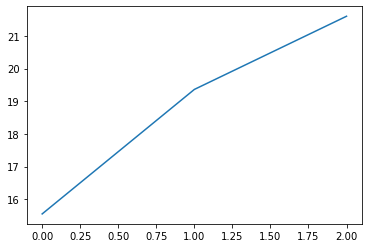

In [147]:
draw_line_by_list([15.55, 19.36, 21.6])

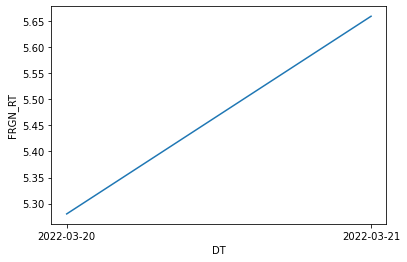

In [98]:
draw_line(df_calc_base, "휴마시스", "FRGN_RT")

<AxesSubplot:xlabel='DT', ylabel='END_PRC'>

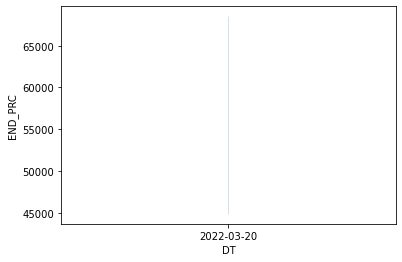

In [149]:
df_calc_base

sns.lineplot(data=df_calc_base, x="DT", y="END_PRC")

In [102]:
df = pd.read_csv("./csv/balance_sheet.csv", encoding="utf-8-sig")
df[df["NM"] == "더네이쳐홀딩스"]

,CD,NM,ROE,PER,PBR,PROFIT,INCOME
48,A298540,더네이쳐홀딩스,"[0.0, 0, 35.28, 0, 33.66, 26.13]","[0.0, 0, 0.0, 0, 6.53, 8.65]","[0, 0, 1.75, 2.0]","[0, 0, 552, 584]","[0, 0, 404, 500]"


In [108]:
cd = "298540"
url = f"https://finance.naver.com/item/main.naver?code={cd}"

list_df = pd.read_html(url, encoding="euc-kr")
df_bs_sheet = list_df[3]
df_bs_sheet = df_bs_sheet.fillna(0)

if ".03" in str(df_bs_sheet["최근 연간 실적"].loc[0]).split(" ")[0]:
    roe = float(df_bs_sheet.fillna(0).iloc[5].loc["최근 연간 실적", "2021.03"][0])
    list_ym = ["2019.03","2020.03","2021.03"]
elif ".06" in str(df_bs_sheet["최근 연간 실적"].loc[0]).split(" ")[0]:
    roe = float(df_bs_sheet.fillna(0).iloc[5].loc["최근 연간 실적", "2021.06"][0])
    list_ym = ["2019.06","2020.06","2021.06"]
elif ".09" in str(df_bs_sheet["최근 연간 실적"].loc[0]).split(" ")[0]:
    roe = float(df_bs_sheet.fillna(0).iloc[5].loc["최근 연간 실적", "2021.09"][0])
    list_ym = ["2019.09","2020.09","2021.09"]
else:
    try:
        roe = float(df_bs_sheet.fillna(0).iloc[5].loc["최근 연간 실적", "2021.12(E)"][0])
        list_ym = ["2018.12","2019.12","2020.12","2021.12(E)"]
    except:
        roe = float(df_bs_sheet.fillna(0).iloc[5].loc["최근 연간 실적", "2021.12"][0])
        list_ym = ["2019.12","2020.12","2021.12"]
list_roe = []        
for ym in list_ym:
    try:
        list_roe.append(float(df_bs_sheet.fillna(0).iloc[5].loc["최근 연간 실적", ym][0]))
    except:
        list_roe.append(0)
        
list_roe

/var/folders/l2/31k7fcdd2xb41np3rpzw20lh0000gn/T/ipykernel_5897/3459785708.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  roe = float(df_bs_sheet.fillna(0).iloc[5].loc["최근 연간 실적", "2021.12(E)"][0])
/var/folders/l2/31k7fcdd2xb41np3rpzw20lh0000gn/T/ipykernel_5897/3459785708.py:27: PerformanceWarning: indexing past lexsort depth may impact performance.
  list_roe.append(float(df_bs_sheet.fillna(0).iloc[5].loc["최근 연간 실적", ym][0]))


[0.0, 35.28, 33.66, 26.13]

In [125]:
import requests

cd = "005930"
pg = 1

headers = {
    "referer" : f"https://finance.naver.com/item/sise_day.naver?code={cd}&page={pg}",    
    "user-agent" : "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/97.0.4692.71 Safari/537.36" 
}

url = f"https://finance.naver.com/item/sise_day.naver?code={cd}&page={pg}"
res = requests.get(url=url, headers=headers)      

# Pandas : read_html() > table element 추출 가능
df_data = pd.read_html(res.text)[0].dropna().set_index("날짜").reset_index()

print(df_data.iloc[0][6])

# 5일평균, 10일 평균, 중위값,
# prc_avg_5, prc_avg_10, vol_avg_5, vol_avg_10, prc_median, vol_median

df_data["NM"] = "AAA"
grouped = df_data.groupby(["NM"]).agg({
    "종가": "mean", "거래량": "mean",
})
grouped.columns = ["PRC_AVG_10", "VOL_AVG_10",]
grouped = grouped.reset_index()
grouped

14241145.0


,NM,PRC_AVG_10,VOL_AVG_10
0,AAA,70430.0,14616470.9


In [56]:
import numpy as np

prc_median = np.median(list(df_data["종가"]))
vol_median = np.median(list(df_data["거래량"]))

print(prc_median, vol_median)

28875.0 25592.0


In [60]:
float(str(grouped["PRC_AVG_10"].iloc[0]))

29065.0

In [132]:
df_pre = pd.read_csv("./csv/day_summary.csv", encoding="utf-8-sig")
# df_pre[df_pre["DT"] == "2022-03-20"].drop(axis=1, inplace=True)
df_pre.drop(df_pre.loc[df_pre['DT'] == "2022-03-20"].index, inplace=True)

df_pre.to_csv("./csv/day_summary.csv", encoding="utf-8-sig", index=False)

In [111]:
str(df_bs_sheet["최근 연간 실적"].loc[0]).split(" ")[0]

'2019.12'